# Naver stock prediction

___Dont trust me :3___

this data is referred to Yahoo Finance.  
the price is KRW

---

\# Loading csv_file and Converting data_frame into time_series

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

filepath = './035420.KS .csv'
df = pd.read_csv(filepath, index_col='Date', parse_dates=True)
ts = df['Close']
ts.head()

Date
2012-02-01    57241.191406
2012-03-01    63737.515625
2012-04-01    62756.941406
2012-05-01    59447.492188
2012-06-01    61286.074219
Name: Close, dtype: float64

\# Removing from missing data and Putting into log function

<AxesSubplot:xlabel='Date'>

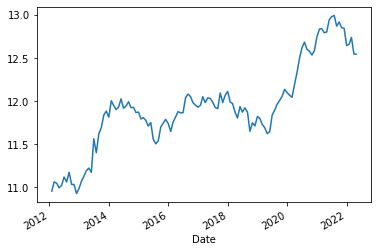

In [2]:
ts = ts.interpolate(method='time')
ts_log = np.log(ts)
ts_log.plot()

\# Data plotting

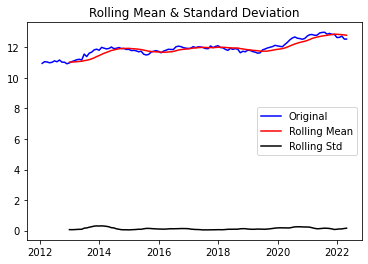

In [3]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  
    rolstd = timeseries.rolling(window=window).std()    

    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

plot_rolling_statistics(ts_log, window=12)

\# Augmented Dicky Fuller Test

In [4]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')      
    
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value',
                                '#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
    
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.605054
p-value                          0.481054
#Lags Used                       0.000000
Number of Observations Used    123.000000
Critical Value (1%)             -3.484667
Critical Value (5%)             -2.885340
Critical Value (10%)            -2.579463
dtype: float64


\# Time Series Decomposition

Results of Dickey-Fuller Test:
Test Statistic                 -4.060798
p-value                         0.001124
#Lags Used                     11.000000
Number of Observations Used    82.000000
Critical Value (1%)            -3.512738
Critical Value (5%)            -2.897490
Critical Value (10%)           -2.585949
dtype: float64


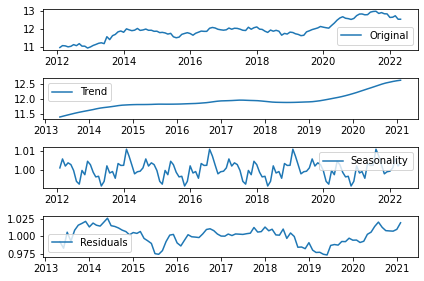

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

---
\# Getting appropriate ARIMA parameter

In [6]:
# ignoring warning!
import warnings
warnings.filterwarnings('ignore')

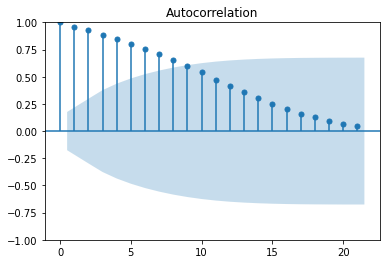

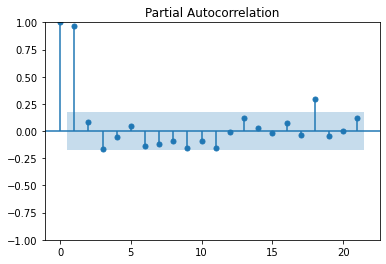

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)
plot_pacf(ts_log)
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.217748e+01
p-value                        1.375656e-22
#Lags Used                     0.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


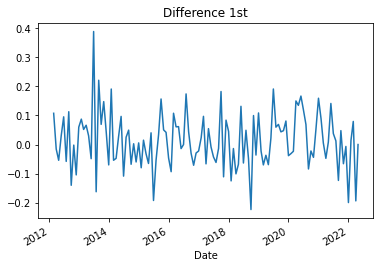

In [8]:
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

We can select by using
 - p + q <= 2
 - pq = 0
 - ACF, PACF, Difference

p = 1, q = 0, d = 1  

 - d : As we can see p-value in 1st diff is enough to be stationary.
 - p, q : With partial autocorrelation, y-value is nearly zero in p > 1.

---
\# The FINAL step; Spliting data and Fitting model

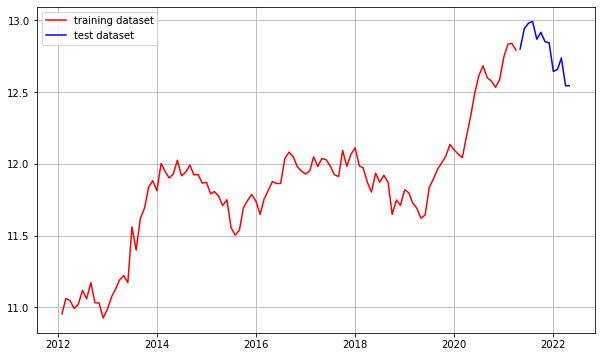

In [9]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(train_data, c='r', label='training dataset')
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [10]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_data, order=(1, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  111
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 101.906
Date:                Fri, 29 Apr 2022   AIC                           -195.812
Time:                        13:14:09   BIC                           -184.974
Sample:                    02-01-2012   HQIC                          -191.416
                         - 04-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.8639      0.688     17.237      0.000      10.515      13.213
ar.L1          0.9925      0.022     44.769      0.000       0.949       1.036
ma.L1         -0.0510      0.098     -0.519      0.6

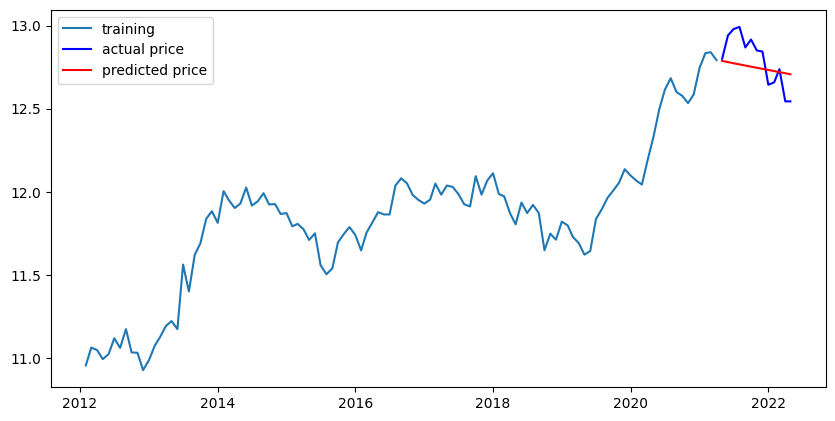

In [11]:
fc = fitted_m.forecast(len(test_data), alpha=0.05)  
fc = np.array(fc)
fc_series = pd.Series(fc, index=test_data.index)   

plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  2535279332.1707463
MAE:  43946.134095751964
RMSE:  50351.55739568287
MAPE: 11.88%


---

So far, we've dealt with Naver's stock.  
Now we will discuss other two examples, Hyundai motor and Kakao inc.  
To simplify steps, leave the important ones and remove the rest.  
  
---
  
# Kakao

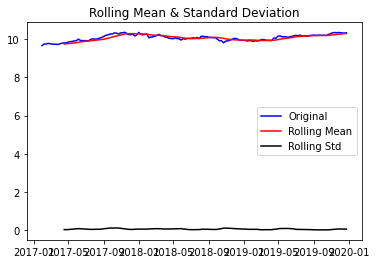

Results of Dickey-Fuller Test:
Test Statistic                  -2.248550
p-value                          0.189099
#Lags Used                       0.000000
Number of Observations Used    151.000000
Critical Value (1%)             -3.474416
Critical Value (5%)             -2.880878
Critical Value (10%)            -2.577081
dtype: float64


In [13]:
filepath = './035720.KS.csv'
df = pd.read_csv(filepath, index_col='Date', parse_dates=True)
ts_log = np.log(df['Close'].interpolate(method='time'))
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

plot_rolling_statistics(ts_log, window=12)
augmented_dickey_fuller_test(ts_log)

# p q d parameter

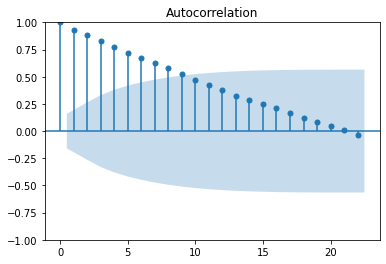

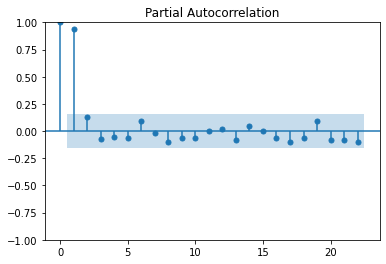

In [14]:
plot_acf(ts_log)
plot_pacf(ts_log)
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -6.435140e+00
p-value                        1.659999e-08
#Lags Used                     4.000000e+00
Number of Observations Used    1.460000e+02
Critical Value (1%)           -3.475953e+00
Critical Value (5%)           -2.881548e+00
Critical Value (10%)          -2.577439e+00
dtype: float64


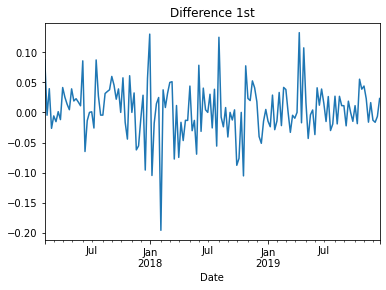

In [15]:
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')
augmented_dickey_fuller_test(diff_1)

 - p + q <= 2
 - pq = 0
 - ACF, PACF, Difference

p = 1, q = 0, d = 1  

 - d : As we can see p-value in 1st diff is enough to be stationary.(if the result is not enough 15%, it can be changed)
 - p, q : With partial autocorrelation, y-value is nearly zero in p > 1.

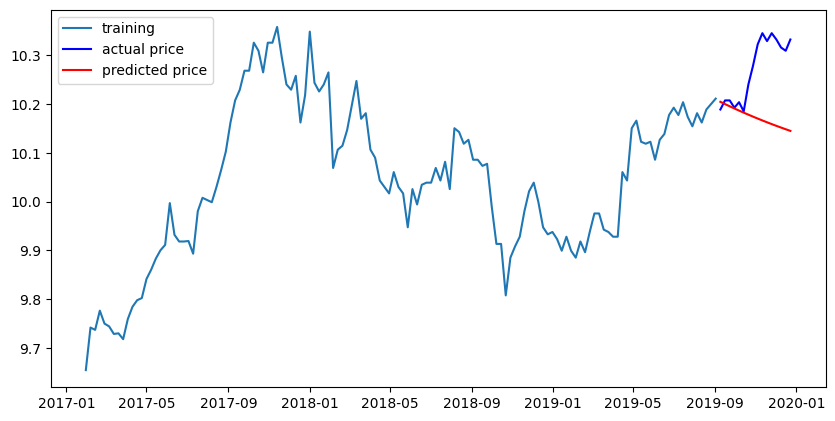

In [16]:
model = ARIMA(train_data, order=(1, 0, 1))  
fitted_m = model.fit() 

fc = fitted_m.forecast(len(test_data), alpha=0.05)  
fc = np.array(fc)
fc_series = pd.Series(fc, index=test_data.index)   

plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [17]:
mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MAPE: 9.22%
